<a href="https://colab.research.google.com/github/shaodwing/nmist-fashion/blob/Adding-callback/Fashion_NMIST_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Used Joseph Redmon on tiny darknet to produce my work
#Used the work of Adrian Rosebrock for the learning rate schedule

import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import backend as K
from keras import utils
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, BatchNormalization, Conv2D, GlobalAveragePooling2D, Activation, LeakyReLU, MaxPooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from clr_callback import *
from learningratefinder import *

#Load Data

In [0]:
np.random.seed(2019)
tf.set_random_seed(2019)

(X_train, Y_train ), (X_test, Y_test ) = fashion_mnist.load_data()

#Tiny dark net

In [18]:
batch_size = 256
num_classes = 10 
epochs = 100
img_cols = X_train.shape[1]
img_rows = X_train.shape[2]

# CLR hyper-parameters
baseLr = 1e-4 #1e-3
maxLr = 2e-1 #2e-1
stepSize = 8
clrMethod = "triangular"

# name file
lrfind_plot_path = os.path.sep.join(["/content/output", "lrfind_plot.png"])
training_plot_path = os.path.sep.join(["/content/output", "training_plot.png"])
clr_plot_path = os.path.sep.join(["/content/output", "clr_plot.png"])

date = datetime.datetime.now().strftime('%b %d %D %M')
saveWeightsPath = '/content/checkpoint' + date


if K.image_data_format() == 'channels_first':
  X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols);
  X_test  = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols);
  input_shape = (1, img_rows, img_cols);
else: 
  X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1);
  X_test  = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1);
  input_shape = (img_rows, img_cols, 1);


X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255
X_test  /= 255

Y_train = utils.to_categorical(Y_train, num_classes)
Y_test  = utils.to_categorical(Y_test, num_classes)
Y_label = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


#Function

In [0]:
def layerConv(output, filters, size, stride, pad, batch_normalization=True, activation='LeakyReLU'):
  output = Conv2D(kernel_size = (size,size), filters = filters, strides=stride, padding=pad)(output)
  if batch_normalization:
    output = BatchNormalization()(output);
  
  #Activation layer
  if activation=='LeakyReLU':
    output = LeakyReLU(alpha = 0.1)(output)
  else:
    output = Activation(activation)(output)
  
  return output


#Tensor model

In [20]:
#LAYERS
#First set of convolution (9-12)
input_img = Input(shape=input_shape)

""" Small darknet
output = layerConv(output=input_img, filters=32, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=8 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=64, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=8 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=64, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')

#Max pooling to get 14x14 feature (13)
output = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None)(output)

output = layerConv(output=output   , filters=16, size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=64, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=16, size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=64, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=16, size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
"""

output = layerConv(output=input_img, filters=128, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=32 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=256, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=32 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output   , filters=256, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')

#Max pooling to get 14x14 feature (13)
output = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None)(output)

#Second set of convolution (14-19)
output = layerConv(output=output, filters=64 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output, filters=256, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU') #512
output = layerConv(output=output, filters=64 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU')
output = layerConv(output=output, filters=256, size=3, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU') #512
output = layerConv(output=output, filters=64 , size=1, batch_normalization=True, stride=1, pad="same", activation='LeakyReLU') #128



#Last layer to get an output of 10 class (19+)
output = layerConv(output=output, filters=10, size=1, batch_normalization=False, stride=1, pad="same", activation='linear')
output = GlobalAveragePooling2D()(output)
output = Activation('softmax')(output)

model = Model(input_img, output)
model.summary()



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 128)       512       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 32)        4128      
_________________________________________________________________
batch_normalization_22 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 28, 28, 32)        0   

In [0]:

#Learning Rate schedule
LearningRateSchedule = CyclicLR( mode=clrMethod,
                                base_lr=baseLr,
                                max_lr=maxLr,
                                step_size= stepSize * (X_train.shape[0] // batch_size))
callbacks = []
callbacks.append(LearningRateSchedule)

checkpointCallback = ModelCheckpoint(saveWeightsPath,
                                     monitor='val_loss',
                                     verbose=0,
                                     save_best_only=True,
                                     save_weights_only=False,
                                     mode='auto',
                                     period=1)
callbacks.append(checkpointCallback)

opt = SGD(lr=baseLr, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
aug = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

#Finding best learning rate

[INFO] finding learning rate...
Epoch 1/9
235/235 [==============================] - 87s 370ms/step - loss: 2.4340 - acc: 0.1450
Epoch 2/9
235/235 [==============================] - 84s 358ms/step - loss: 2.4341 - acc: 0.1463
Epoch 3/9
235/235 [==============================] - 84s 358ms/step - loss: 2.4336 - acc: 0.1470
Epoch 4/9
235/235 [==============================] - 84s 357ms/step - loss: 2.4261 - acc: 0.1569
Epoch 5/9
235/235 [==============================] - 84s 357ms/step - loss: 2.3404 - acc: 0.2161
Epoch 6/9
235/235 [==============================] - 84s 358ms/step - loss: 1.7668 - acc: 0.4250
Epoch 7/9
235/235 [==============================] - 84s 358ms/step - loss: 0.8186 - acc: 0.7617
Epoch 8/9
235/235 [==============================] - 84s 358ms/step - loss: 0.4945 - acc: 0.8231
Epoch 9/9
222/235 [===========================>..] - ETA: 4s - loss: 0.8857 - acc: 0.7745[INFO] learning rate finder complete
[INFO] examine plot and adjust learning rates before training


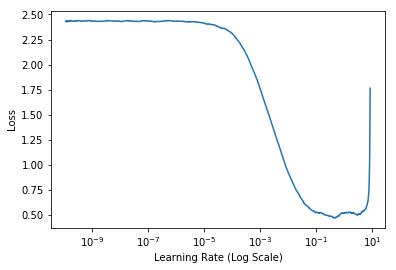

In [22]:
findBestLR = False
if findBestLR:
  
  # Search for the best learning rate
  # initialize the learning rate finder and then train with learning
  # rates ranging from 1e-10 to 1e+1
  print("[INFO] finding learning rate...")
  lrf = LearningRateFinder(model)
  lrf.find(
    aug.flow(X_train, Y_train, batch_size=batch_size),
    1e-10, 1e+1,
    stepsPerEpoch=np.ceil((len(X_train) / float(batch_size))),
    batchSize=4)#batch_size)

  # plot the loss for the various learning rates and save the
  # resulting plot to disk
  lrf.plot_loss()
  #plt.savefig(lrfind_plot_path)

  # gracefully exit the script so we can adjust our learning rates
  # in the config and then train the network for our full set of
  # epochs
  print("[INFO] learning rate finder complete")
  print("[INFO] examine plot and adjust learning rates before training")

#Training


In [15]:
"""
model.fit(X_train, Y_train,
          epochs=epochs,
          batch_size=batch_size,
          shuffle=True, 
          validation_data=(X_test, Y_test),
          callbacks=callbacks)
"""
model.fit_generator(aug.flow(X_train, Y_train,
                            batch_size=batch_size,
                            shuffle=True, seed=None),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    callbacks=callbacks)

Epoch 1/100
234/234 [==============================] - 24s 102ms/step - loss: 1.5175 - acc: 0.5187 - val_loss: 9.6263 - val_acc: 0.0972
Epoch 2/100
234/234 [==============================] - 23s 97ms/step - loss: 0.5697 - acc: 0.8016 - val_loss: 2.5854 - val_acc: 0.5139
Epoch 3/100
234/234 [==============================] - 23s 97ms/step - loss: 0.4430 - acc: 0.8439 - val_loss: 1.1857 - val_acc: 0.6344
Epoch 4/100
234/234 [==============================] - 23s 97ms/step - loss: 0.3974 - acc: 0.8592 - val_loss: 1.2203 - val_acc: 0.6238
Epoch 5/100
234/234 [==============================] - 23s 97ms/step - loss: 0.3656 - acc: 0.8710 - val_loss: 1.4777 - val_acc: 0.5524
Epoch 6/100
234/234 [==============================] - 23s 97ms/step - loss: 0.3478 - acc: 0.8777 - val_loss: 2.4261 - val_acc: 0.5967
Epoch 7/100
234/234 [==============================] - 23s 97ms/step - loss: 0.3327 - acc: 0.8821 - val_loss: 0.8515 - val_acc: 0.7536
Epoch 8/100
234/234 [==============================] -

KeyboardInterrupt: ignored

In [0]:
predictions = model.predict(X_test, batch_size=batch_size)
print(classification_report(y_true=Y_test.argmax(axis=1),
                            y_pred=predictions.argmax(axis=1),
                            target_names=Y_label))